# Week 7 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests, io, re, nltk
import cPickle as pickle
from os import listdir
from os.path import isfile, join

%matplotlib inline

## Processing real text (from out on the inter-webs)

*Exercise:* Just a couple of examples from the book: Work through the exercises NLPP1e 3.12: 6, 30.

** Describe the class of strings matched by the following regular expressions. **
1. [a-zA-Z]+ -> all words that can be in lowercase or capital letters
2. [A-Z][a-z]* -> A single capital letter, or a word starting by a capital letter and followed by lowercase letters (a word at the begining of the sentence)
3. p[aeiou]{,2}t -> All words starting by a p and ending by a t, with between 0 and 2 characters from aeio in between
4. \d+(\.\d+)? -> Captures the decimal part of a number, with the leading point
5. ([^aeiou][aeiou][^aeiou])* -> Any word containing a letter in aeiou, that isn't directly precedeed by any of those letters, and not followed by any of those letters. 
6. \w+|[^\w\s]+ -> Match literally any character (either a word or anything that is not a word). 


** Use the Porter Stemmer to normalize some tokenized text, calling the stemmer on each word. Do the same thing with the Lancaster Stemmer and see if you observe any differences.**

In [2]:
raw= """
The gold dollar was a coin struck as a regular issue by the United States Bureau of the Mint from 1849 to 1889. The coin had three types over its lifetime, all designed by Mint Chief Engraver James B. Longacre. The Type 1 issue had the smallest diameter of any United States coin ever minted. A gold dollar had been proposed several times in the 1830s and 1840s, but was not initially adopted. Congress was finally galvanized into action by the increased supply of bullion from the California gold rush, and in 1849 authorized a gold dollar. In its early years, silver coins were being hoarded or exported, and the gold dollar found a ready place in commerce. Silver again circulated after Congress required in 1853 that new coins of that metal be made lighter, and the gold dollar became a rarity in commerce even before federal coins vanished from circulation amid the economic disruption of the American Civil War. Gold did not circulate again in most of the nation until 1879, and even then, the gold dollar did not regain its place in commerce. In its final years, struck in small numbers, it was hoarded by speculators and mounted in jewelry.
"""
tokens = nltk.word_tokenize(raw)

porter = nltk.PorterStemmer()

print [porter.stem(t) for t in tokens]

[u'The', u'gold', u'dollar', u'wa', u'a', u'coin', u'struck', u'as', u'a', u'regular', u'issu', u'by', u'the', u'Unit', u'State', u'Bureau', u'of', u'the', u'Mint', u'from', u'1849', u'to', u'1889', u'.', u'The', u'coin', u'had', u'three', u'type', u'over', u'it', u'lifetim', u',', u'all', u'design', u'by', u'Mint', u'Chief', u'Engrav', u'Jame', u'B.', u'Longacr', u'.', u'The', u'Type', u'1', u'issu', u'had', u'the', u'smallest', u'diamet', u'of', u'ani', u'Unit', u'State', u'coin', u'ever', u'mint', u'.', u'A', u'gold', u'dollar', u'had', u'been', u'propos', u'sever', u'time', u'in', u'the', u'1830', u'and', u'1840', u',', u'but', u'wa', u'not', u'initi', u'adopt', u'.', u'Congress', u'wa', u'final', u'galvan', u'into', u'action', u'by', u'the', u'increas', u'suppli', u'of', u'bullion', u'from', u'the', u'California', u'gold', u'rush', u',', u'and', u'in', u'1849', u'author', u'a', u'gold', u'dollar', u'.', u'In', u'it', u'earli', u'year', u',', u'silver', u'coin', u'were', u'be', u'h

In [3]:
lancaster = nltk.LancasterStemmer()

print [lancaster.stem(t) for t in tokens]

['the', 'gold', 'doll', 'was', 'a', 'coin', 'struck', 'as', 'a', 'regul', 'issu', 'by', 'the', 'unit', 'stat', 'bureau', 'of', 'the', 'mint', 'from', '1849', 'to', '1889', '.', 'the', 'coin', 'had', 'three', 'typ', 'ov', 'it', 'lifetim', ',', 'al', 'design', 'by', 'mint', 'chief', 'engrav', 'jam', 'b.', 'longacr', '.', 'the', 'typ', '1', 'issu', 'had', 'the', 'smallest', 'diamet', 'of', 'any', 'unit', 'stat', 'coin', 'ev', 'mint', '.', 'a', 'gold', 'doll', 'had', 'been', 'propos', 'sev', 'tim', 'in', 'the', '1830s', 'and', '1840s', ',', 'but', 'was', 'not', 'init', 'adopt', '.', 'congress', 'was', 'fin', 'galv', 'into', 'act', 'by', 'the', 'increas', 'supply', 'of', 'bul', 'from', 'the', 'californ', 'gold', 'rush', ',', 'and', 'in', '1849', 'auth', 'a', 'gold', 'doll', '.', 'in', 'it', 'ear', 'year', ',', 'silv', 'coin', 'wer', 'being', 'hoard', 'or', 'export', ',', 'and', 'the', 'gold', 'doll', 'found', 'a', 'ready', 'plac', 'in', 'commerc', '.', 'silv', 'again', 'circ', 'aft', 'congr

The words are case sensitive in the Porter stemmer whereas in the Lancaster they are all in lowercase. 

## Words that characterize the branches

*Exercises:* TF-IDF and the branches of philosophy.

Setup. We want to start from a clean version of the philosopher pages with as little wiki-markup as possible. We needed it earlier to get the links, etc, but now we want a readable version. We can get a fairly nice version directly from the wikipedia API, simply call prop=extracts&exlimit=max&explaintext instead of prop=revisions as we did earlier. This will make the API return the text without links and other markup.

* **Use this method to retrive a nice copy of all philosopher's text. You can, of course, also clean the existing pages using regular expressions, if you like (but that's probably more work).**

In [4]:
wikipedia_root_api_url = "http://en.wikipedia.org/w/api.php"
philosophers_dir = './philosophers'

def download_wikipage(philosopher):
    payload = {
        'action': 'query',
        'format': 'json',
        'prop': 'extracts',
        'exlimit': 'max',
        'explaintext': 'true',
        'titles': philosopher
    }
    
    response = requests.get(wikipedia_root_api_url, params=payload)
    content = response.json()
    
    # If there are no pages associated to the philosopher, just skip it 
    if 'pages' not in content['query']:
        return None
        
    philosopher_pages = content['query']['pages']
    philosopher_content = philosopher_pages[philosopher_pages.keys()[0]]
    
    # If there's no content in the page, skip it as well 
    if 'extract' not in philosopher_content:
        return None
    
    return content

def save_to_file(file_name, json):
    with io.open('./' + philosophers_dir + '/' + file_name + '.pickle', 'wb') as f:
        pickle.dump(json, f)
        
def load_philosophers_from_file(file_name):
    f = io.open(file_name, 'r', encoding='utf-8')

    # Find all matches
    philosophers_matches = re.findall(re_wiki_link, f.read())
    return set(philosophers_matches)


In [5]:
# More advanced regex that captures links with whitespaces and doesn't require any manual pre-processing of the file
re_wiki_link = r'\*.*?\[\[([^\[\]|]+)[^\[\]]*\]\]' 


def create_philosophers_dict():
    philosophers_branches = {}
    
    aestheticians_matches = load_philosophers_from_file('philosophers_aestheticians.txt')
    epistemologists_matches = load_philosophers_from_file('philosophers_epistemologists.txt')
    ethicists_matches = load_philosophers_from_file('philosophers_ethicists.txt')
    logicians_matches = load_philosophers_from_file('philosophers_logicians.txt')
    metaphysicians_matches = load_philosophers_from_file('philosophers_metaphysicians.txt')
    sociopoliticians_matches = load_philosophers_from_file('philosophers_sociopolitical.txt')
    
    philosophers_unique = aestheticians_matches.union(epistemologists_matches) \
                                                .union(ethicists_matches) \
                                                .union(logicians_matches) \
                                                .union(logicians_matches) \
                                                .union(metaphysicians_matches) \
                                                .union(sociopoliticians_matches)
                        
    philosophers_unique = set(philosophers_unique)
    
    # Check if philosopher is in branch_name, and add the branch to his list of branches if so
    def if_philosopher_in_branch(philosopher, content, branch_name, branch_matches):
        if philosopher in branch_matches:
            if branch_name in philosophers_branches:
                philosophers_branches[branch_name][philosopher] = content
            else:
                # If the philosopher is not yet in the dictionary, create a new dict with the current branch
                philosophers_branches[branch_name] = {philosopher: content}
                
    
    # Helper method to check in each branch
    def check_if_philosopher_in_one_branch(philosopher):
        # Download content
        content = download_wikipage(philosopher)
        if not content:
                return
        philosopher_pages = content['query']['pages']
        philosopher_content = philosopher_pages[philosopher_pages.keys()[0]]

        philosopher_content = philosopher_content['extract']
            
        if_philosopher_in_branch(philosopher, philosopher_content, 'aestheticians', aestheticians_matches)
        if_philosopher_in_branch(philosopher, philosopher_content, 'epistemologists', epistemologists_matches)
        if_philosopher_in_branch(philosopher, philosopher_content, 'ethicists', ethicists_matches)
        if_philosopher_in_branch(philosopher, philosopher_content, 'logicians', logicians_matches)
        if_philosopher_in_branch(philosopher, philosopher_content, 'metaphysicians', metaphysicians_matches)
        if_philosopher_in_branch(philosopher, philosopher_content, 'sociopoliticians', sociopoliticians_matches)
    
    
    # For each philosopher, check in which branch they belong to
    for philosopher in philosophers_unique:
        check_if_philosopher_in_one_branch(philosopher)
        
    return philosophers_branches

# # Get all the files with the philosophers information
# philosopher_files = get_list_of_philosophers_files(philosophers_dir)

# philosophers_content = {}

# for philosopher_file in philosopher_files:
#     philosopher_wikipage = load_philosopher_from_file(philosopher_file)
    
#     philosopher_pages = philosopher_wikipage['query']['pages']
#     philosopher_content = philosopher_pages[philosopher_pages.keys()[0]]
#     philosopher_name = philosopher_content['title']
    
#     philosophers_content[philosopher_name] = philosopher_content
    
#     content = download_wikipage(philosopher_name)
#     save_to_file(philosopher_name + '-extract', content)

In [6]:
philosopher_branches = create_philosophers_dict()

* **First, check out the wikipedia page for TF-IDF. Explain in your own words the point of TF-IDF. **

TF-IDF is a measure in information retrieval that captures how important a word is in a document compared to a a list of corpuses. A term will have a high TF-IDF if it appears frequently in a document but infrequently in other documents, whereas a term that appears frequently in all documents won't have a high TF-IDF.  
* 
    * ** What does TF stand for?  ** TF stands for Term Frequency
    * ** What does IDF stand for? **  IDF stands for Inverse Document Frequency 


* **Since we want to find out which words are important for each branch, so we're going to create six large documents, one per branch of philosophy. Tokenize the pages, and combine the tokens into one long list per branch. Remember the bullets below for success.**

In [49]:
import string 
philosopher_branches_tokens = {}

# Collect english stopwords 
stopwords = set(nltk.corpus.stopwords.words('english'))

def is_alphanum(input_string):
    # TODO See if we need to do not all here instead (do we accept punctuation in words ?)
    return all(char.isalnum() for char in input_string)

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Loop through each branch
for branch, philosophers in philosopher_branches.iteritems():
    #print len(philosophers)
    tokens_current_branch = {}
    # Collect for each branch the tokens
    for philosopher, content in philosophers.iteritems():
        tokens = nltk.word_tokenize(content)
        philosopher_name = philosopher.lower()
        
        # Go through each token and check if we keep it
        for token in tokens:
            token_lower = token.lower()
            # if token is a part of the philosopher name, not alphanum (like punctuation), is a stopword, 
            # or is a number, discard it
            if len(token_lower) == 1 \
            or not is_alphanum(token_lower) \
            or is_number(token_lower) \
            or token_lower in philosopher_name \
            or token_lower in stopwords: \
                continue
            # Add the token to the tokens of the current branch
            if token_lower in tokens_current_branch:
                tokens_current_branch[token_lower] += 1
            else:
                tokens_current_branch[token_lower] = 1
    
    # Add the complete list of tokens to the branch 
    philosopher_branches_tokens[branch] = tokens_current_branch

NameError: name 'philosopher_branches' is not defined

* **Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within each branch. **

In [10]:
philosopher_branches_tokens_frequency = {}

for branch, tokens in philosopher_branches_tokens.iteritems():
    freq_tokens = [(token, 1+ np.log10(count)) for token, count in tokens.iteritems()]
    freq_tokens_sorted = sorted(freq_tokens, key=lambda (k,v): -v)
    philosopher_branches_tokens_frequency[branch] = freq_tokens_sorted
    print "The top 5 terms for the branch %s are : %s" % (branch, freq_tokens_sorted[:5])

The top 5 terms for the branch sociopoliticians are : [(u'university', 4.3694014136966244), (u'philosophy', 4.3484995702838383), (u'political', 4.2720737875000099), (u'also', 4.238046103128795), (u'new', 4.2166935991697549)]
The top 5 terms for the branch aestheticians are : [(u'philosophy', 4.064832219738574), (u'university', 3.9781805169374138), (u'one', 3.9717395908877782), (u'work', 3.9047155452786808), (u'also', 3.8992731873176036)]
The top 5 terms for the branch logicians are : [(u'logic', 4.2955670999624793), (u'university', 4.1931245983544621), (u'philosophy', 4.1535099893008374), (u'theory', 4.0157787563890412), (u'also', 3.9708116108725178)]
The top 5 terms for the branch epistemologists are : [(u'philosophy', 4.0927206446840998), (u'university', 3.9355072658247128), (u'one', 3.9138138523837167), (u'also', 3.8656960599160706), (u'theory', 3.7767011839884108)]
The top 5 terms for the branch metaphysicians are : [(u'philosophy', 4.1849751906982604), (u'university', 3.9827233876

* 
    * **Describe similarities and differences between the branches.**
    
    A
    * ** Why aren't the TFs not necessarily a good description of the branches? **
    
    A

* **Next, we calculate IDF for every word. **

In [11]:
import numpy as np
from __future__ import division

N = len(philosopher_branches) # Number of branches

word_idf = {}

for branch, tokens in philosopher_branches_tokens.iteritems():
    for token in tokens:
        token_count = 0
        for _, tokens1 in philosopher_branches_tokens.iteritems():
            if token in tokens1:
                token_count += 1
        word_idf[token] = np.log10(N / token_count)

* 
    * ** What base logarithm did you use? Is that important? **
    
    A

* **We're ready to calculate TF-IDF. Do that for each branch. **

In [12]:
philosophers_branches_idf = {}

for branch, tfs in philosopher_branches_tokens_frequency.iteritems():
    for (word, tf) in tfs:
        if branch in philosophers_branches_idf:
            philosophers_branches_idf[branch].append((word, tf *  word_idf[word], tf, word_idf[word]))
        else:
            philosophers_branches_idf[branch] = [(word, tf *  word_idf[word], tf, word_idf[word])]

* 
    * **List the 10 top words for each branch.**

In [14]:
for branch, words_tf_idf in philosophers_branches_idf.iteritems():
    words_tf_idf_sorted = sorted(words_tf_idf, key=lambda (w, tf_idf, tf, idf): -tf_idf)
    print "Top 10 words for branch %s : %s\n" % (branch, words_tf_idf_sorted[:10])

Top 10 words for branch sociopoliticians : [(u'jinnah', 2.1324166533346305, 2.7403626894942441, 0.77815125038364363), (u'shinto', 2.1134613978955761, 2.7160033436347994, 0.77815125038364363), (u'manila', 2.0492367715551381, 2.6334684555795866, 0.77815125038364363), (u'maulana', 2.0162401637824745, 2.5910646070264991, 0.77815125038364363), (u'tokugawa', 1.9796697297722379, 2.5440680443502757, 0.77815125038364363), (u'sacer', 1.9597847714246148, 2.5185139398778875, 0.77815125038364363), (u'meccans', 1.9161180810072533, 2.4623979978989561, 0.77815125038364363), (u'v\xf6lkisch', 1.9161180810072533, 2.4623979978989561, 0.77815125038364363), (u'hathaway', 1.9161180810072533, 2.4623979978989561, 0.77815125038364363), (u'wong', 1.8919687532177984, 2.4313637641589874, 0.77815125038364363)]

Top 10 words for branch aestheticians : [(u'somaesthetics', 1.9161180810072533, 2.4623979978989561, 0.77815125038364363), (u'concerto', 1.8919687532177984, 2.4313637641589874, 0.77815125038364363), (u'queens

* 
    * **Are these 10 words more descriptive of the branch? If yes, what is it about IDF that makes the words more informative?**
    
    A
* **Normally, TF-IDF is used for single documents. What does TF-IDF tell us about the content of a single document in a collection.**

A

## The word cloud.

## Sentiment Analysis

*Exercise, sentiment over some books from NLPP1e*

* **Download the LabMT wordlist. It's available as supplementary material from Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter (Data Set S1). Describe briefly how the list was generated.**

In [50]:
words_happiness = {}
with open('./Data_Set_S1.txt') as f:
    # Skip the first 4 lines (header lines)
    for _ in xrange(4):
        next(f)
    for line in f:
        content = line.split('\t')
        word, happiness_avg = content[0], content[2]
        words_happiness[word] = float(happiness_avg)

The list was generated by assessing for random words their general happiness. This assessment was done through Mechanical Turk, which is a service that pays humans to complete simple tasks. 
For each word, we have its happiness rank, followed by the average happiness rating, and standard deviation.

* **Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc). The function should complain if there are no words with sentiment attached.**

In [107]:
from __future__ import division

# Collect english stopwords 
stopwords = set(nltk.corpus.stopwords.words('english'))

def get_sentiment(tokens, return_words_no_sentiment=False, show_warning=False):
    combined_happiness = 0
    words_with_no_sentiment = set()
    words_sentiment_count = 0
    
    # Filter tokens to keep those worth looking at : more than 2 characters, with letters, and not a stopword
    tokens_filtered = [w.lower() for w in tokens if len(w) > 2 and w.isalpha() and w not in stopwords]
    
    # Go through each token and if we have a sentiment for it, add it to the combined happiness score
    for token in tokens_filtered:
        if token in words_happiness:
            combined_happiness += words_happiness[token]
            words_sentiment_count += 1
        else:
            words_with_no_sentiment.add(token)
            
    # If we didn't find any sentiment for the tokens, print a warning message (if option is enabled)
    if words_sentiment_count == 0 and show_warning:
        print "No sentiment attached to words"
    
    # Safe check to avoid division by 0
    if words_sentiment_count == 0: 
        avg_sentiment_score = 0 
    else: 
        avg_sentiment_score = combined_happiness / words_sentiment_count
    
    # If we need to return the words without sentiment score (for debugging purpose), add them
    if return_words_no_sentiment:
        return avg_sentiment_score, words_with_no_sentiment
    else:
        return avg_sentiment_score

* **Calculate a sentiment profile for the novels in NLPP1e chapter 1. The sentiment profile has sentiment on the y-axis and position in the text on the x-axis. Use a moving average to show how the sentiment changes. Create profiles for sliding windows of length 15 words, 50 words, 100 words, 500 words.**

In [108]:
from nltk.book import *

# Create a list of all novels
novels = [text1, text2, text3, text4, text5, text6, text7, text8, text9]

# For each novel, print happiness score and the percentage of tokens we found with a sentiment
for text in novels:
    happiness_score, words_no_sentiment = get_sentiment(text.tokens, return_words_no_sentiment=True)
    print "%s:" % text
    print "Happiness score: %f" % happiness_score
    percentage = (1 - (len(words_no_sentiment) / len(text1.tokens))) * 100
    print "Percentage of tokens with sentiment: %.2f \n" % percentage

<Text: Moby Dick by Herman Melville 1851>:
Happiness score: 5.514543
Percentage of tokens with sentiment: 95.61 

<Text: Sense and Sensibility by Jane Austen 1811>:
Happiness score: 5.648094
Percentage of tokens with sentiment: 98.85 

<Text: The Book of Genesis>:
Happiness score: 5.644708
Percentage of tokens with sentiment: 99.51 

<Text: Inaugural Address Corpus>:
Happiness score: 5.699635
Percentage of tokens with sentiment: 98.23 

<Text: Chat Corpus>:
Happiness score: 5.709195
Percentage of tokens with sentiment: 99.28 

<Text: Monty Python and the Holy Grail>:
Happiness score: 5.531843
Percentage of tokens with sentiment: 99.79 

<Text: Wall Street Journal>:
Happiness score: 5.538418
Percentage of tokens with sentiment: 98.38 

<Text: Personals Corpus>:
Happiness score: 6.292589
Percentage of tokens with sentiment: 99.93 

<Text: The Man Who Was Thursday by G . K . Chesterton 1908>:
Happiness score: 5.489541
Percentage of tokens with sentiment: 98.90 



In [113]:
def compute_moving_avg(window_size, tokens):
    # Compute the middle position of the window 
    window_half_pos = window_size / 2 
    
    sentiment_profile = []
    start = 0
    while start < len(tokens):
        # Get tokens for this window
        window_tokens = tokens[start:start + window_size]
        
        window_sentiment = get_sentiment(window_tokens)
        
        # Get position we'll display by taking the middle position of the window offseted by the start index
        window_pos = start + window_half_pos
        
        sentiment_profile.append((window_pos, window_sentiment))
        
        # Update start position (to move to the next window)
        start += window_size
        
    return sentiment_profile

def plot_sentiment_novel(novel, sentiment_profile, window_size):
    # Retrieve positions and sentiments (and don't take any with a 0 sentiment score for nicer vizualisations)
    positions = [position for position, sentiment in sentiment_profile if sentiment != 0]
    sentiments = [sentiment for _, sentiment in sentiment_profile if sentiment != 0]
    
    # Plot sentiment profile 
    plt.figure(figsize=(14, 8))
    plt.plot(positions, sentiments)
    plt.title("Sentiment profile for %s (window size: %d)" % (novel, window_size))
    plt.xlabel("Position in text")
    plt.ylabel("Sentiment score")
    plt.show()

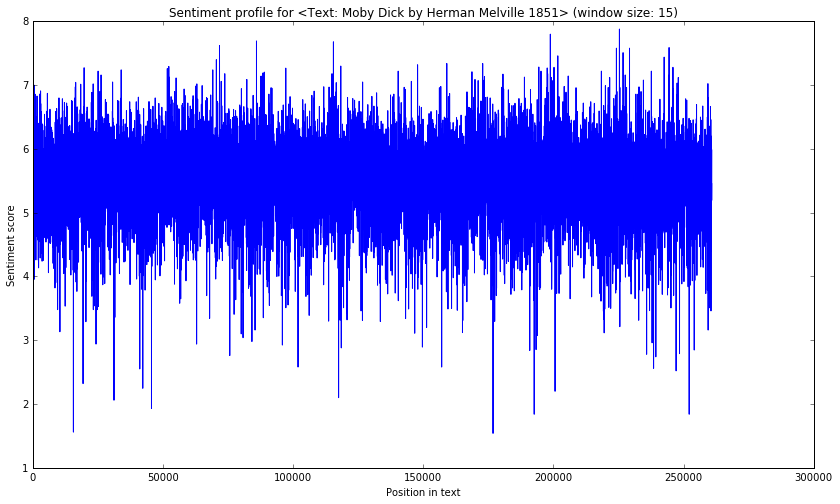

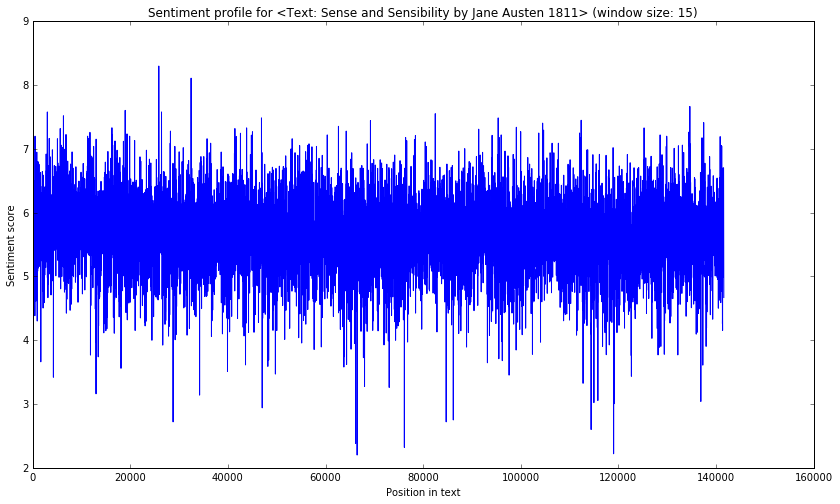

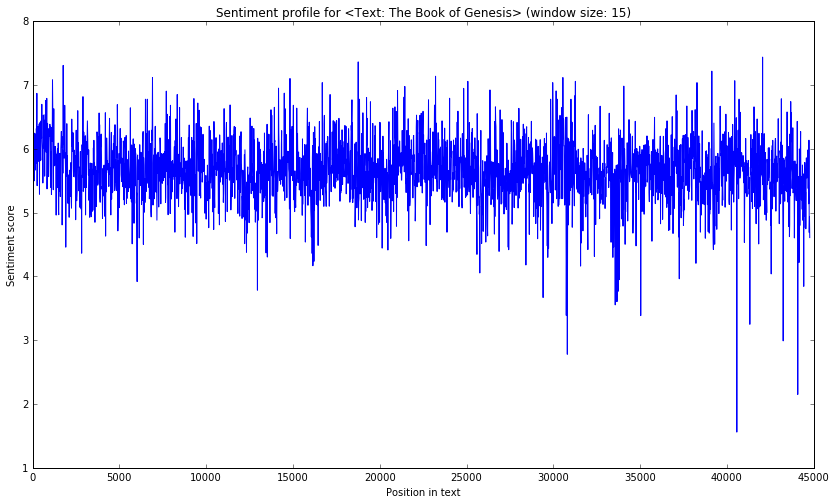

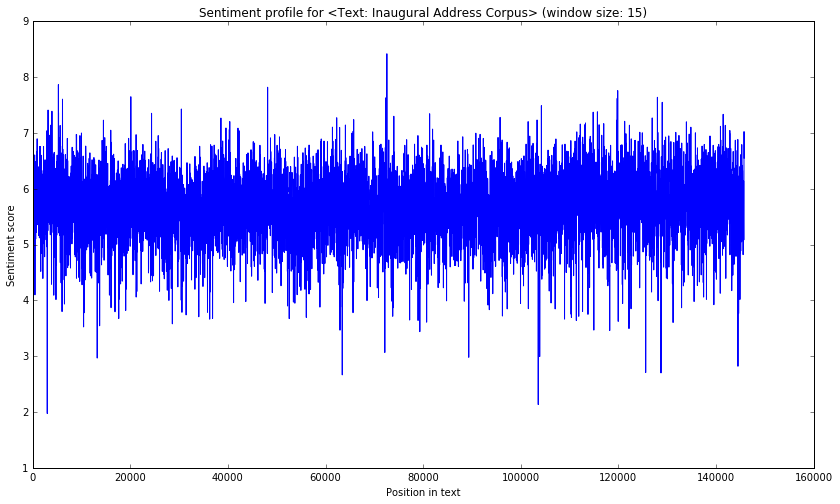

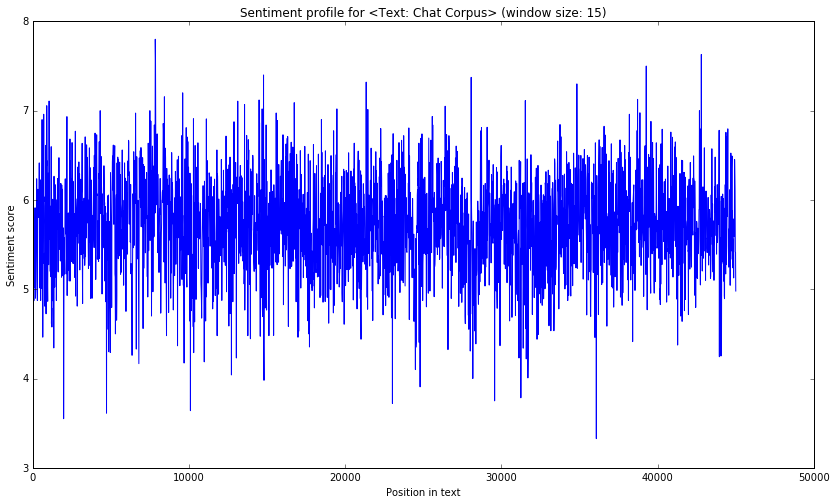

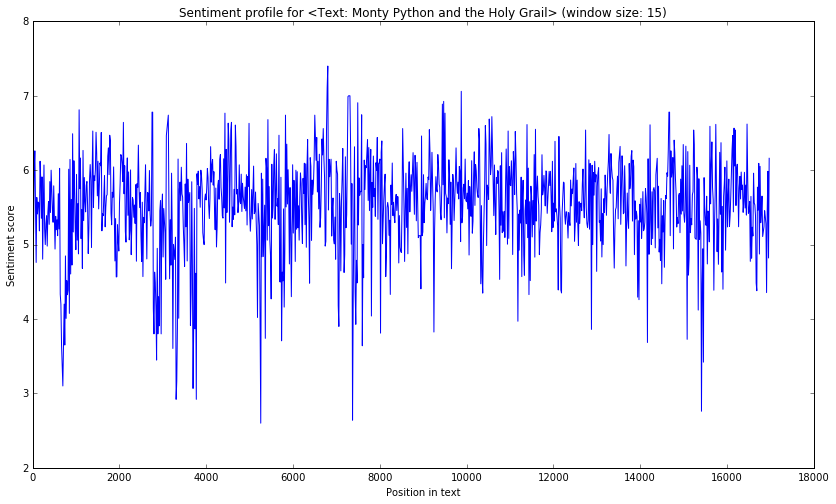

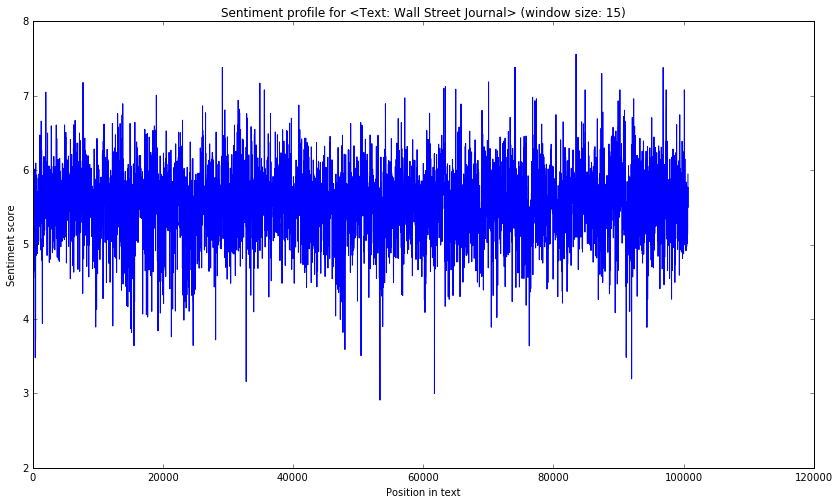

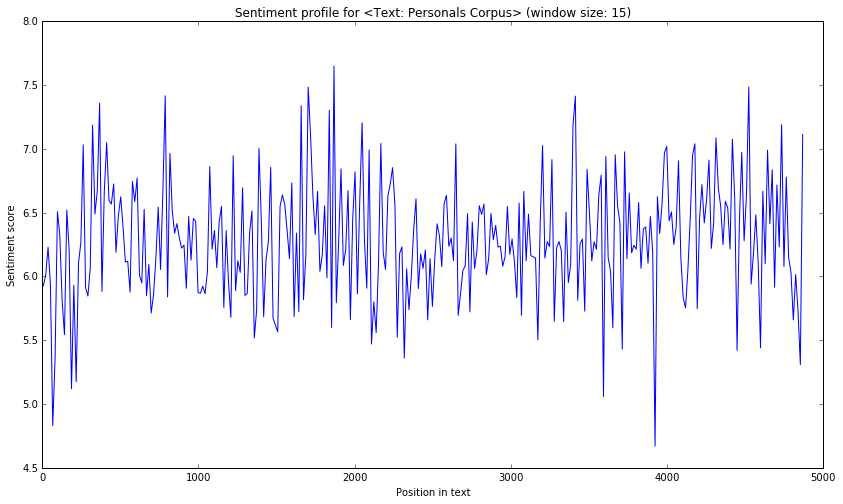

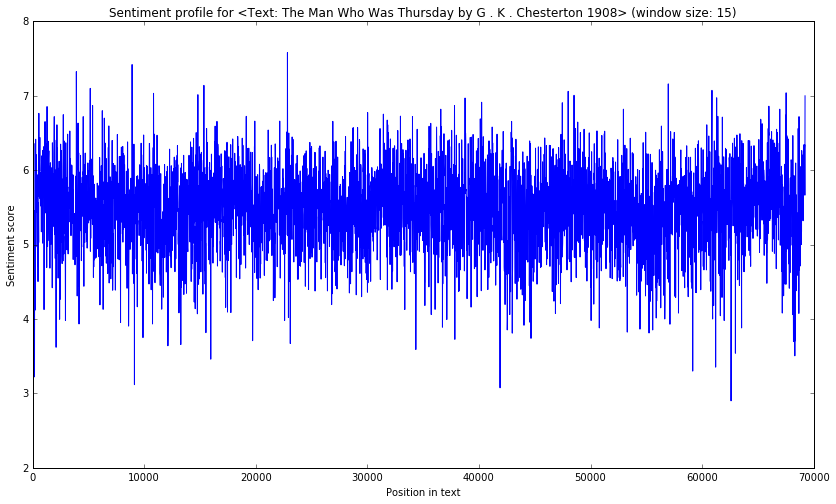

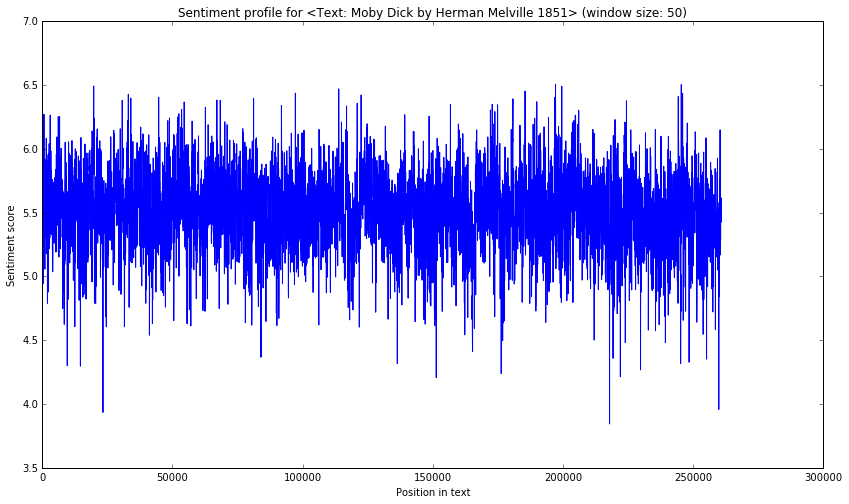

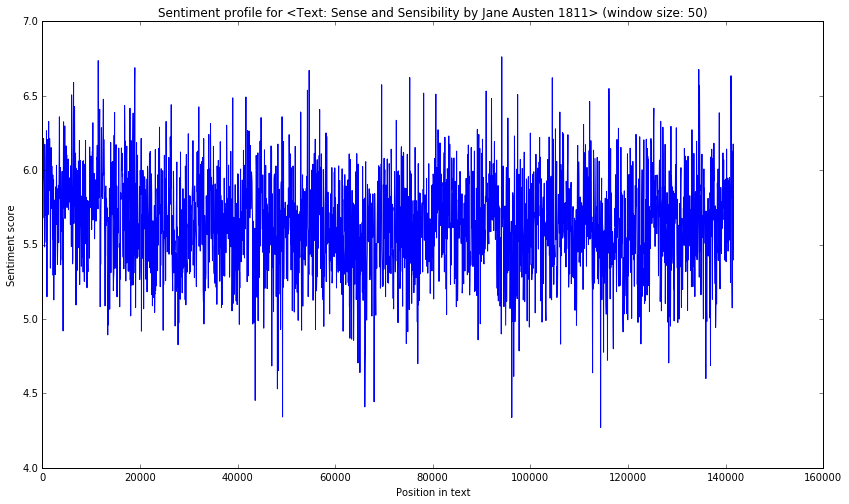

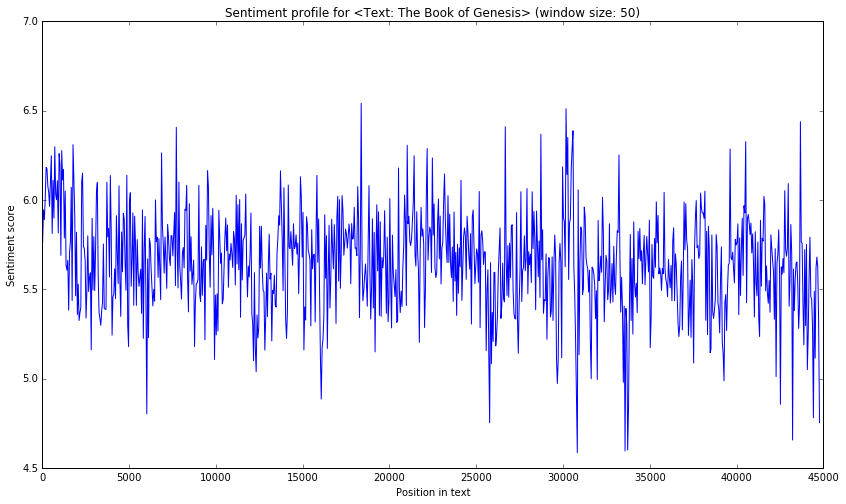

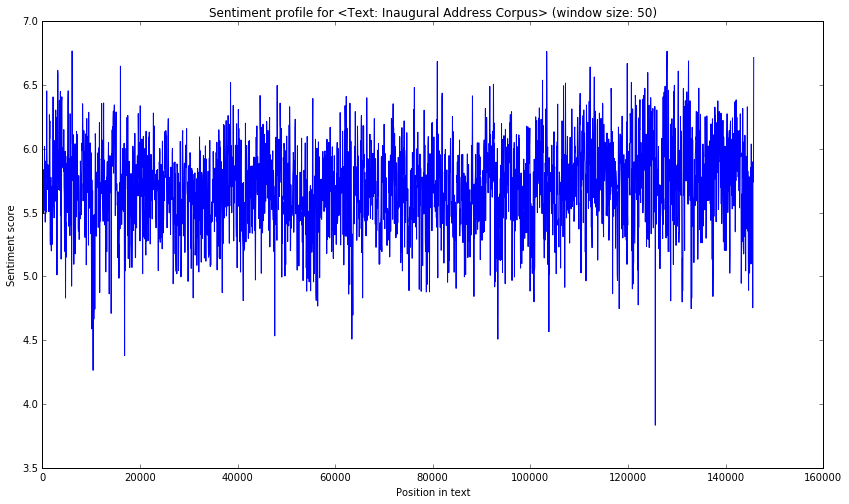

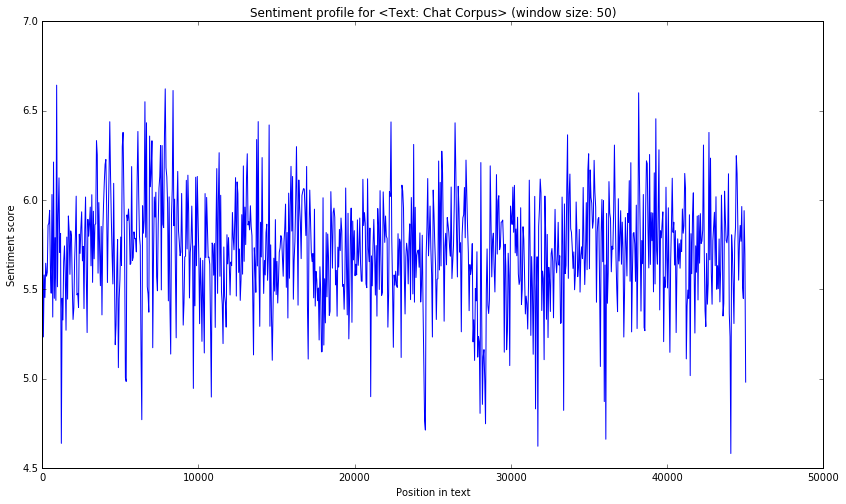

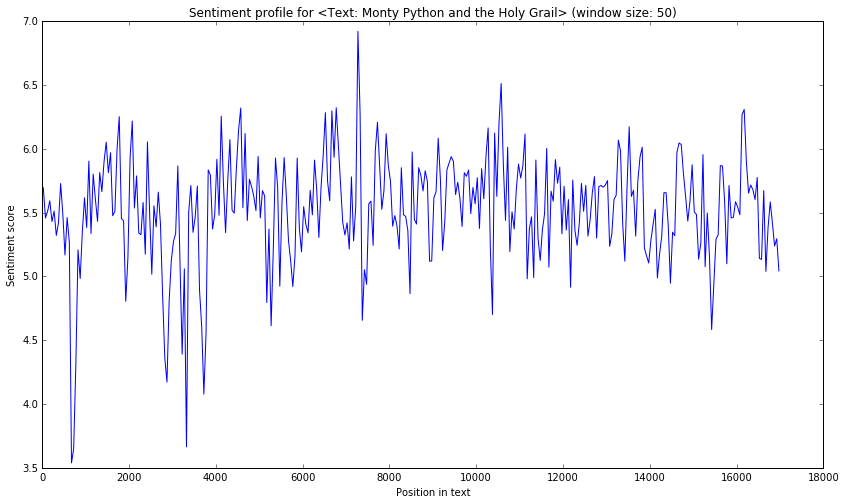

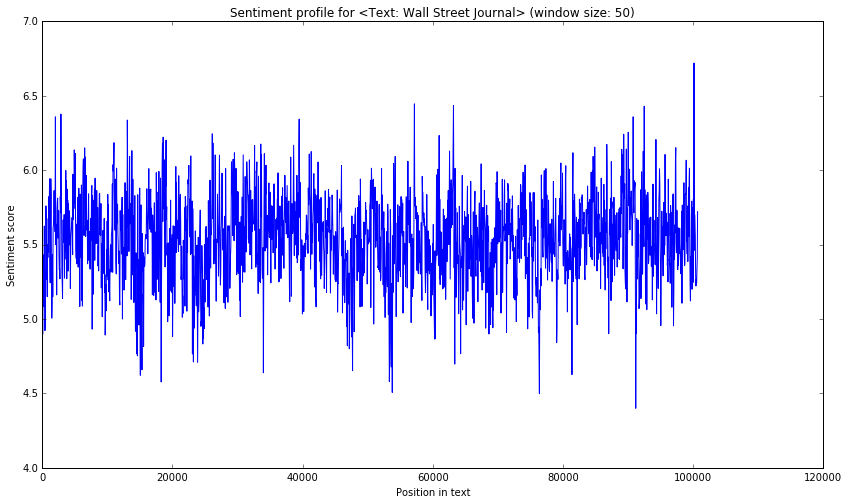

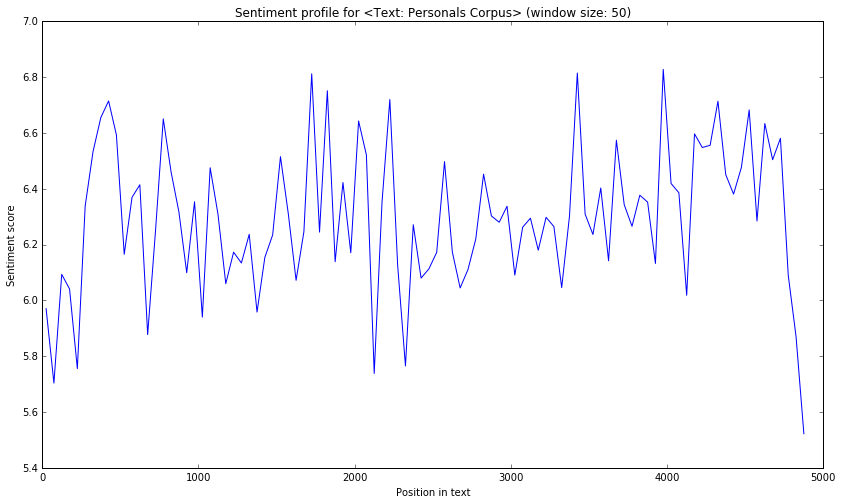

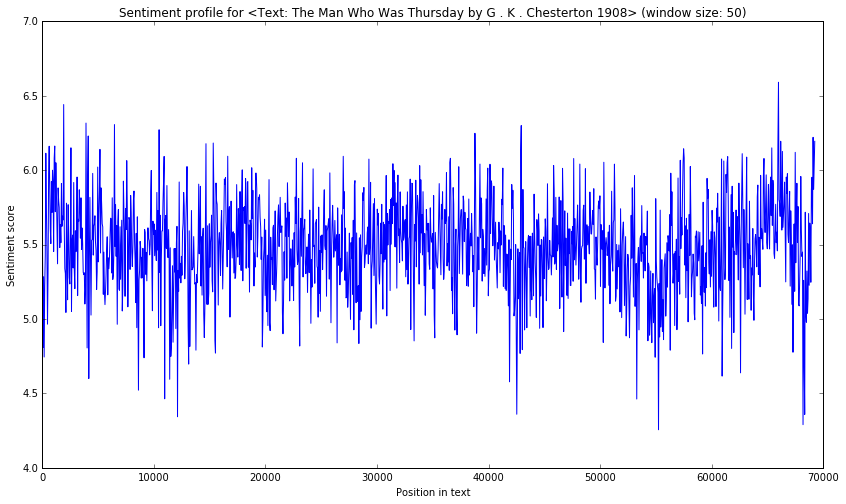

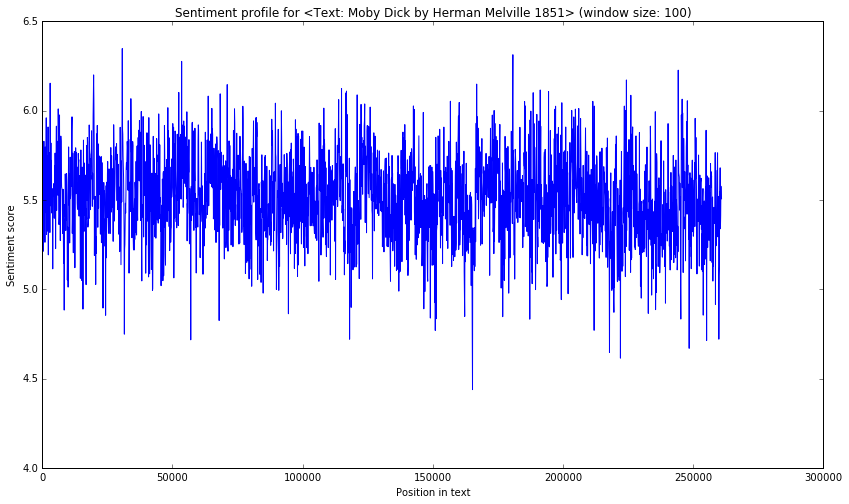

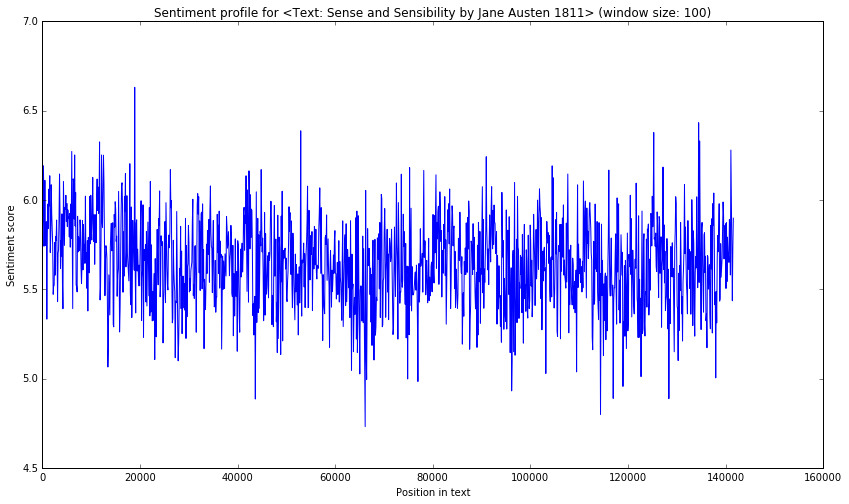

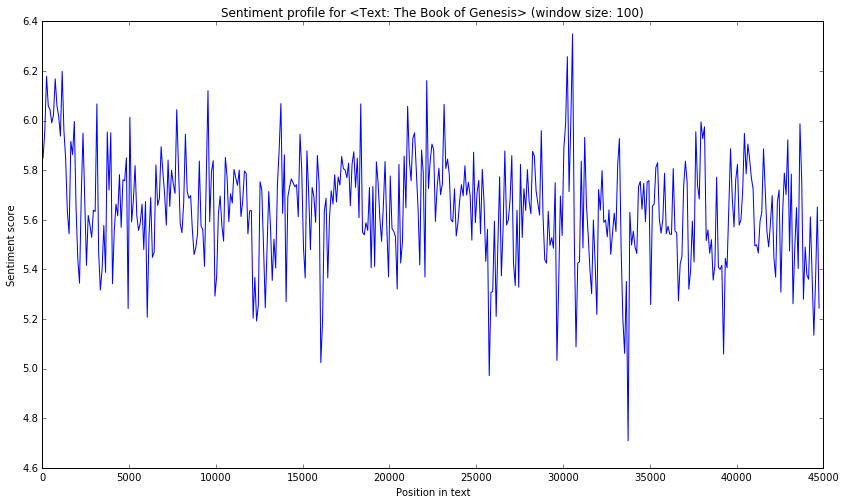

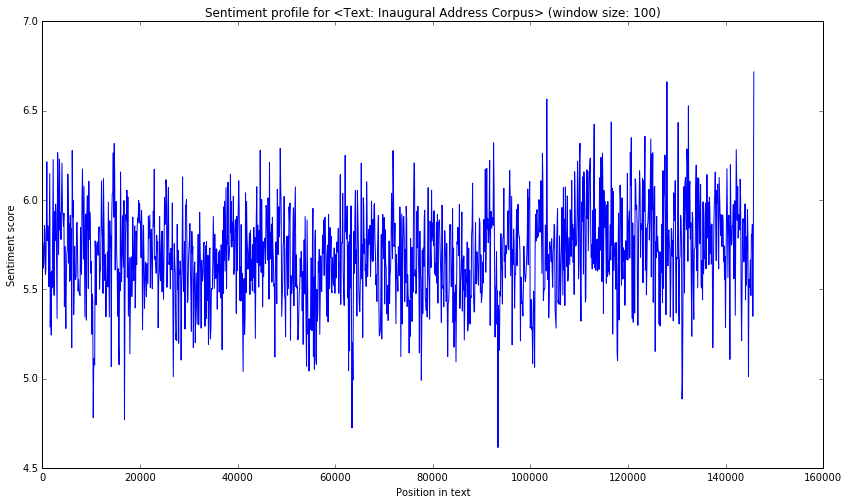

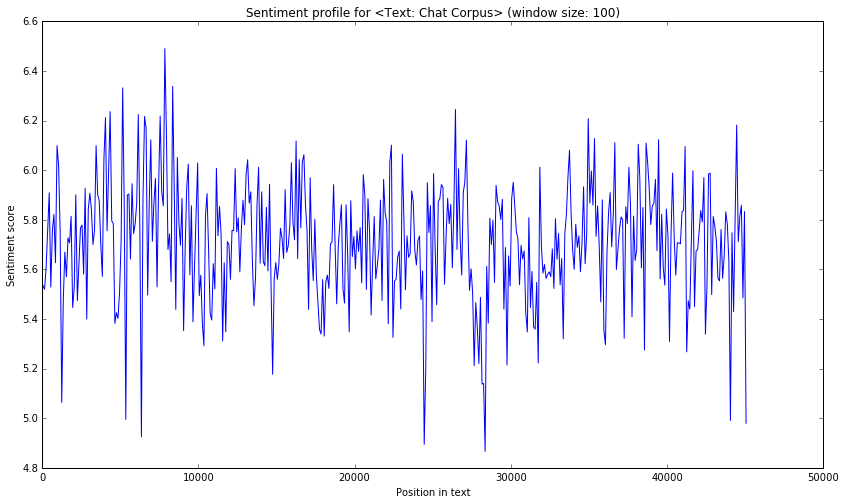

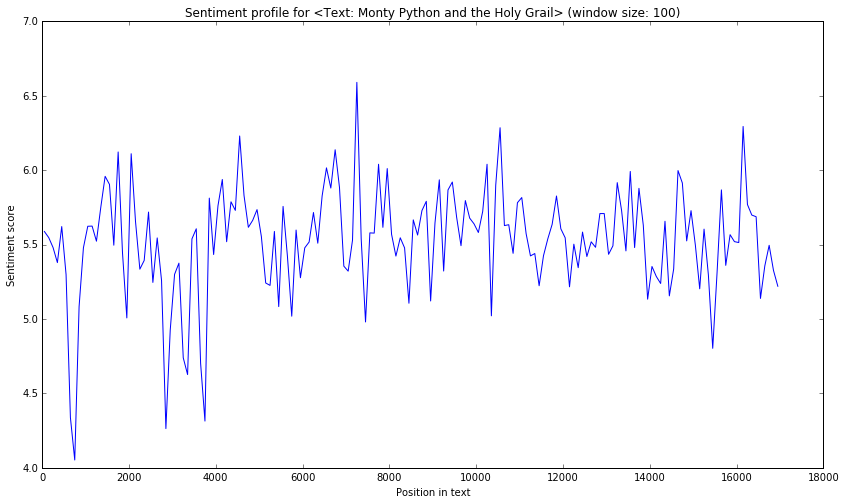

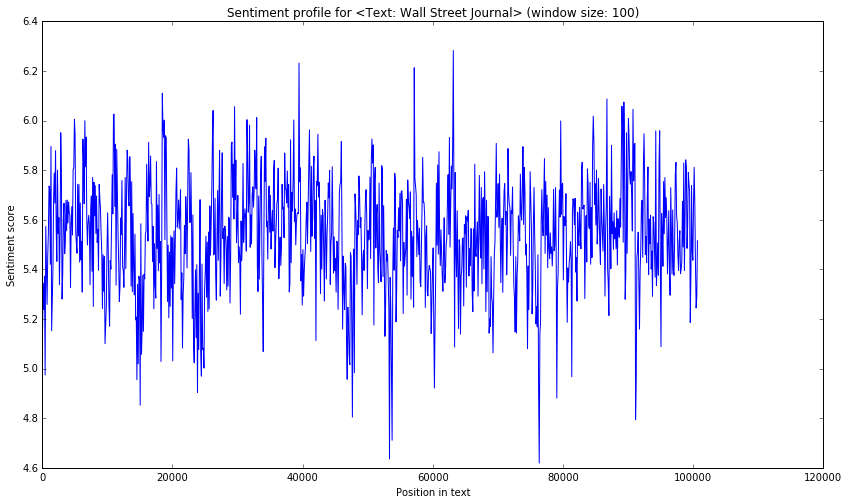

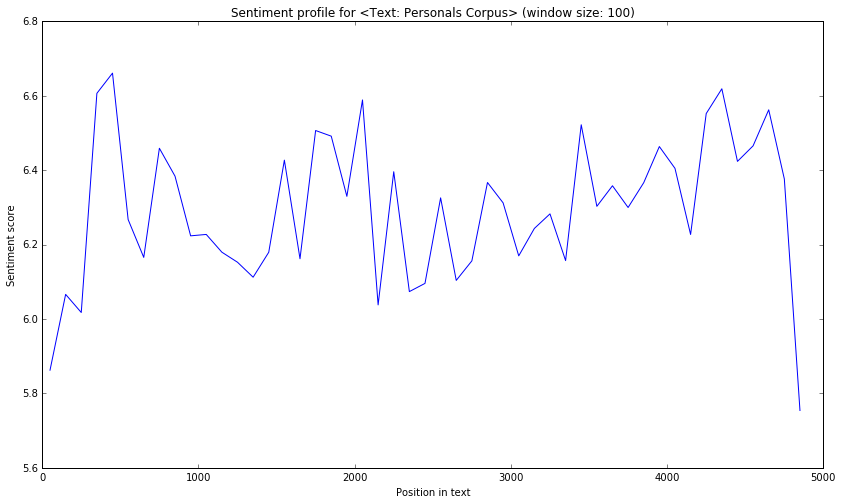

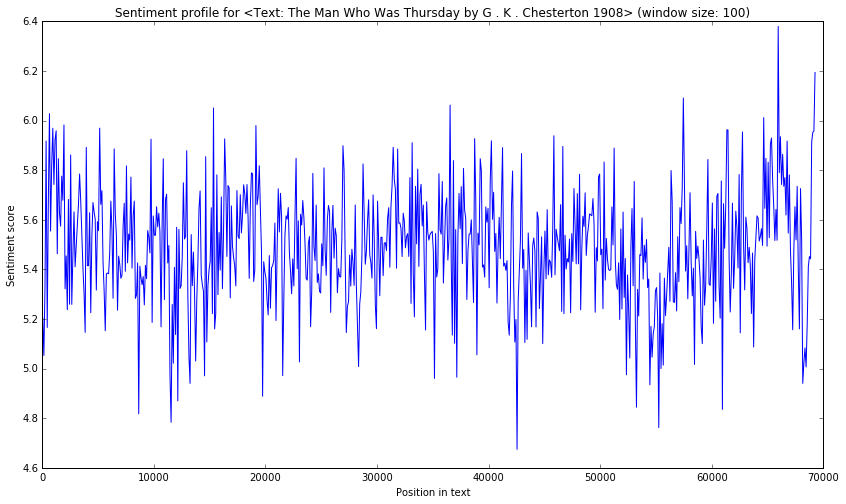

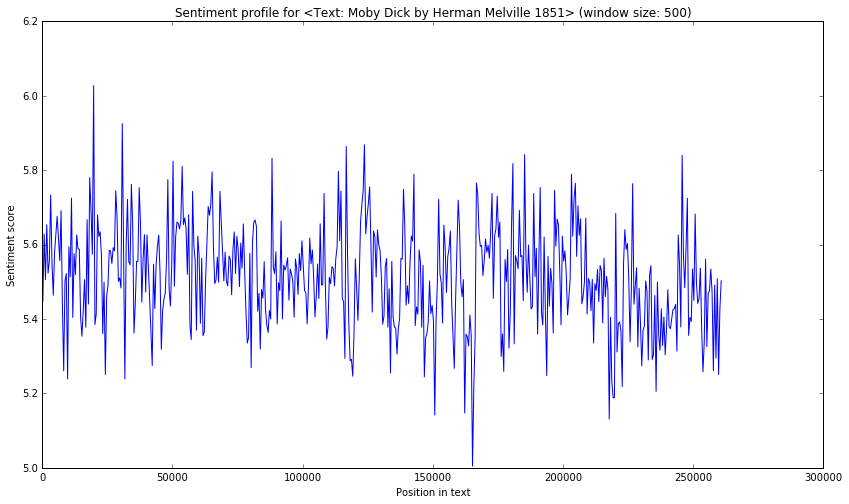

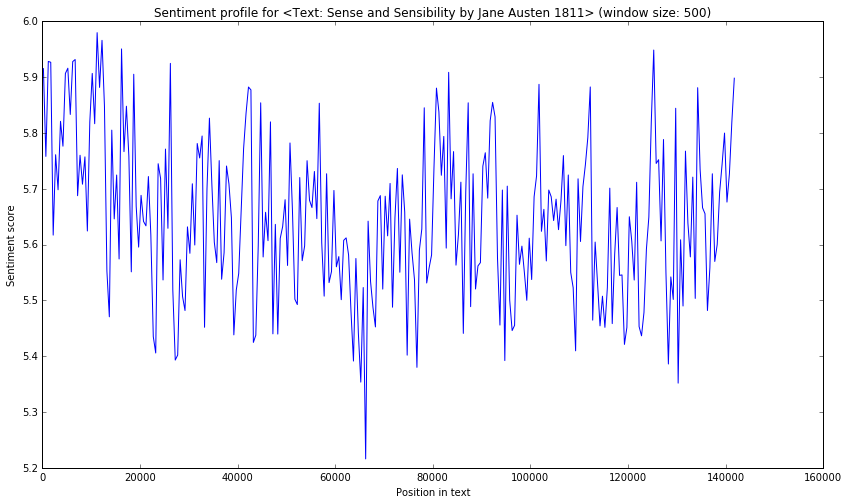

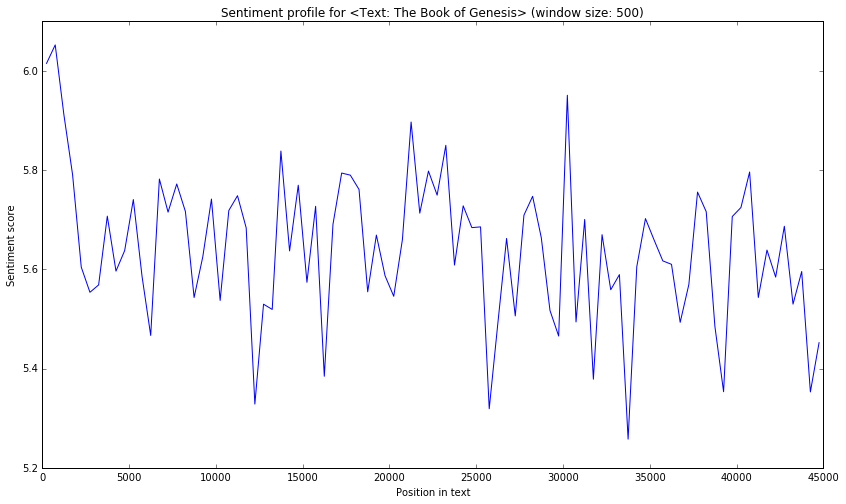

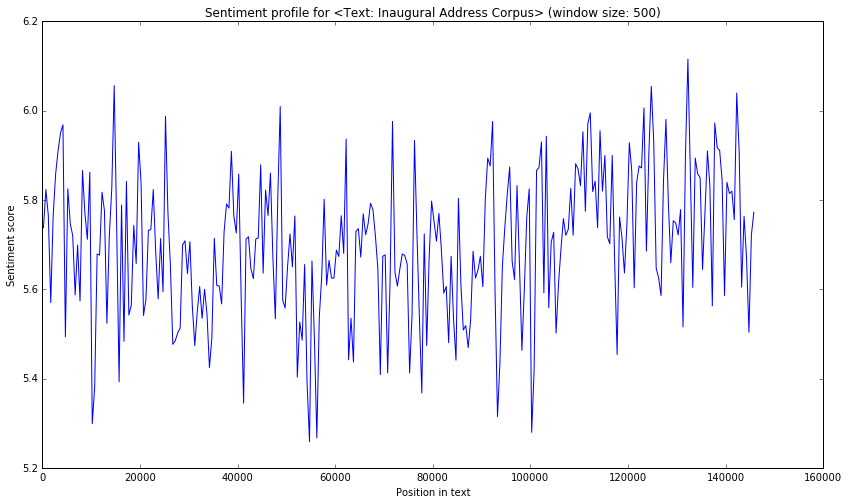

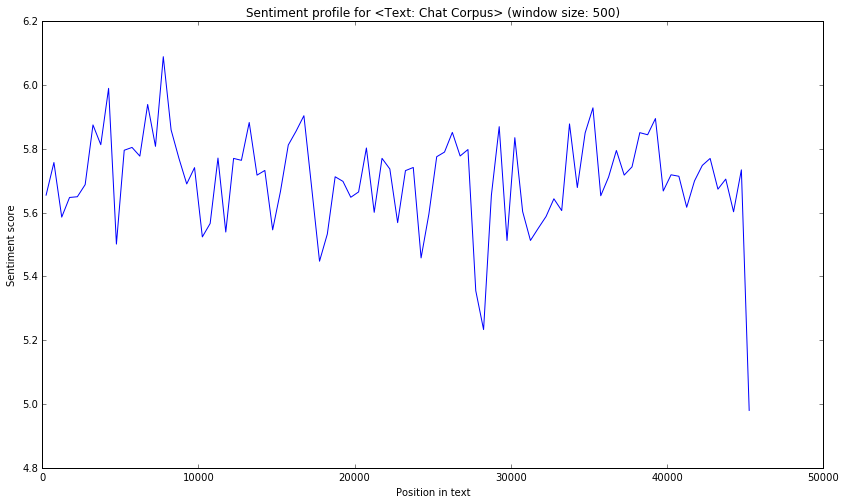

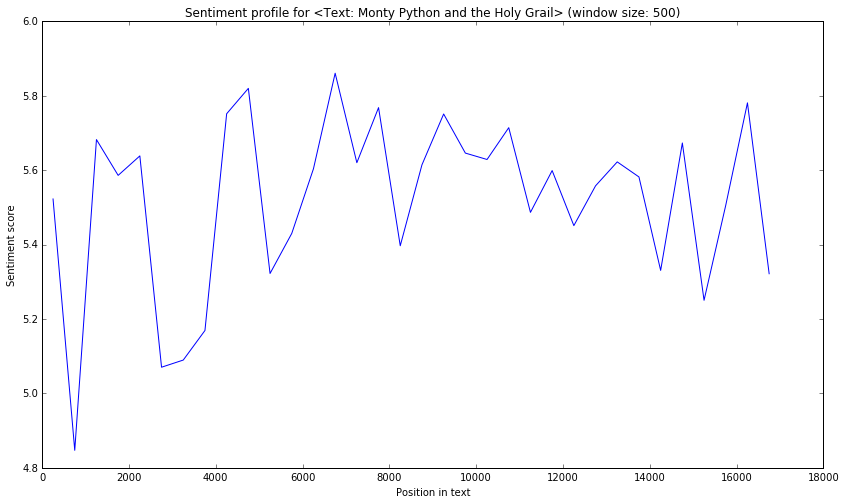

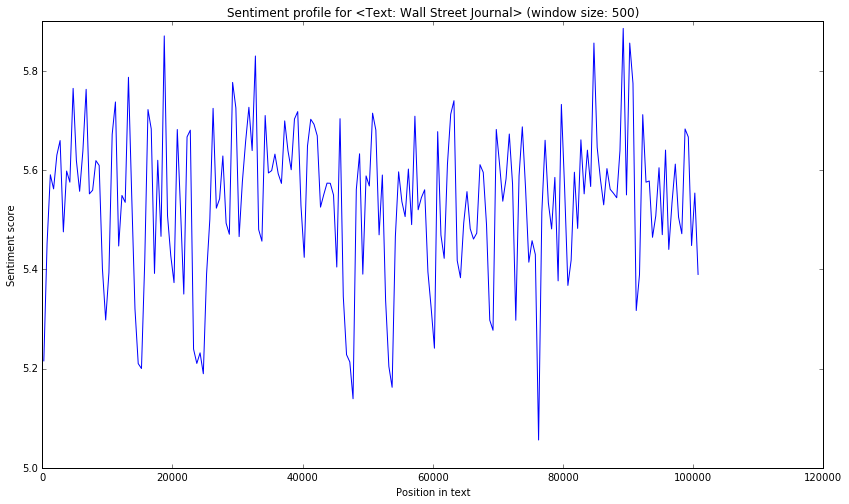

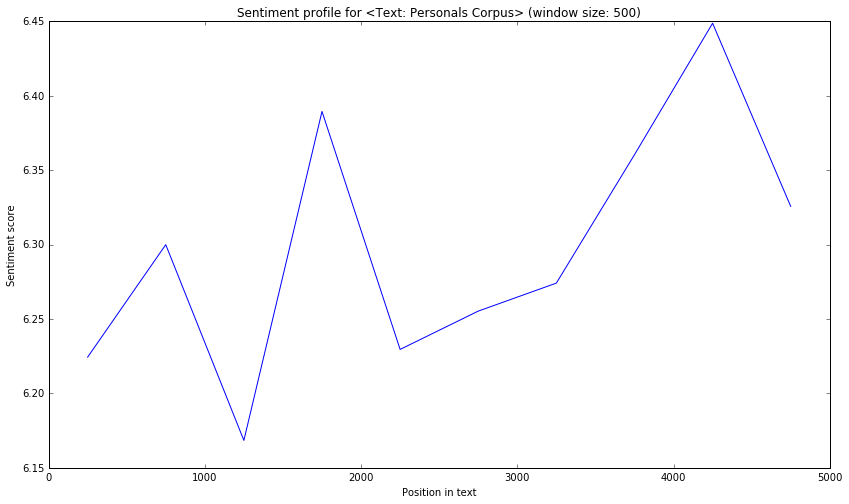

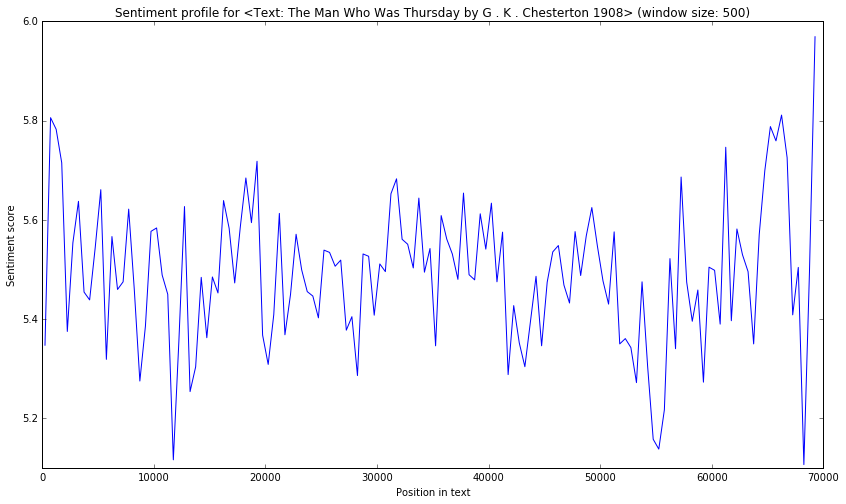

In [114]:
# Create a list with the window sizes
moving_avg_values = [15, 50, 100, 500]

# For each window size, plot the sentiment profile for each novel
for moving_avg_size in moving_avg_values:
    for text in novels:
        sentiment_profile = compute_moving_avg(moving_avg_size, text.tokens)
        plot_sentiment_novel(text, sentiment_profile, moving_avg_size)

* **Comment on the sentiment profiles. Do they show a similar pattern? What is the effect of changing the size of the sliding window?**

It is important to notice that not all novels have the same number of words explaining why we see plots with very high densities and others that are simple curves. 

We can see that readers of those novels experience a rollercoaster of emotions throughout the book, with generally the novel starts rapidly increasing at a high happiness score, presumably to make the readers comfortable (exceptions exist such as The Book of Genesis). In many cases, the novels tend to finish on a high happiness score compared to the happiness score sustained through the book, correlating to the happy ending theory (but not all finish on a happy note). 

As such, we can say that the novels tend to follow a similar pattern, where the reader is taken through highs and lows in the story. 

When the sliding window is low, the plot is denser as there are more points to display. By increasing the window size, we eliminate the noise from localized "emotions" and focus on the bigger picture, the general sentiment that is conveyed, but at the expense of loosing the variation of sentiment existing in a book. For example, for text8 (Personal Corpus), we loose important information with a window size of 500, contrary to text7 (Wall Street Journals) where it is more insightful to focus on the bigger window sizes as the text is big. 
